In [1]:
from sms.data.utils.pyramid_embedding_dataloader2 import PyramidEmbeddingDataloader
from sms.encoders.image_encoder import BaseImageEncoderConfig
from sms.encoders.openclip_encoder import OpenCLIPNetworkConfig
from torch.utils import data
import torch.nn as nn
from typing import Dict, ForwardRef, Generic, List, Literal, Optional, Tuple, Type, Union, cast, get_args, get_origin
from torchvision import transforms
import matplotlib.pyplot as plt
from nerfstudio.utils.colormaps import apply_colormap
import torch
from matplotlib.patches import Circle
from pathlib import Path
import os.path as osp
import os
from autolab_core import RigidTransform
import cv2
from autolab_core.points import PointCloud, RgbCloud, Point
import json
import open3d as o3d
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class RGBDClipImagePose():
    def __init__(self,rgb_image,depth_image,pose,intrinsics,width,height):
        self.width_ = width
        self.height_ = height
        self.rgb_image = rgb_image
        self.depth_image = depth_image
        self.clip_relevancy_ = None
        self.pose = pose
        self.intrinsics_ = intrinsics
        self.fx_ = self.intrinsics_[0,0]
        self.cx_ = self.intrinsics_[0,2]
        self.fy_ = self.intrinsics_[1,1]
        self.cy_ = self.intrinsics_[1,2]
        self.pointcloud_cam_frame_,self.rgbcloud_cam_frame_,self.subsample_pointcloud_cam_frame_,self.subsample_rgbcloud_cam_frame_ = self.getPointcloud(depth_image)
        
    def getPointcloud(self, depth_image):
        rows, cols = depth_image.shape
        y, x = np.meshgrid(range(rows), range(cols), indexing="ij")

        # Convert needle depth image to x,y,z pointcloud
        Z = depth_image
        X = (x - self.cx_) * Z / self.fx_
        Y = (y - self.cy_) * Z / self.fy_
        points = np.stack((X,Y,Z),axis=-1)
        rgbs = self.rgb_image
        
        # Remove all 0's
        non_zero_indices = np.all(points != [0, 0, 0], axis=-1)
        points = points[non_zero_indices]
        rgbs = rgbs[non_zero_indices]
        
        points = points.reshape(-1,3)
        rgbs = rgbs.reshape(-1,3)
        points = PointCloud(points.T,self.pose.from_frame)
        rgbs = RgbCloud(rgbs.T,self.pose.from_frame)
        (subsample_pts,subsample_indices) = points.subsample(4,random=True)
        subsample_rgbs = rgbs._data[:,subsample_indices]
        return points,rgbs,subsample_pts,subsample_rgbs

def constructRGBDClipImagePoses(image_folder,depth_folder,pose_file_path):
    image_files = sorted(os.listdir(image_folder))
    depth_files = sorted(os.listdir(depth_folder))
    pose_data = None
    # Load JSON data as a dictionary
    with open(pose_file_path, 'r') as json_file:
        pose_data = json.load(json_file)
    intrinsics = np.array([[pose_data['fl_x'],0,pose_data['cx']],
                        [0,pose_data['fl_y'],pose_data['cy']],
                        [0,0,1]])
    width = pose_data['w']
    height = pose_data['h']
    i = 0
    open3d_coordinate_frames = []
    nerf_frame_to_image_frame = np.array([[1,0,0,0],
                                        [0,-1,0,0],
                                        [0,0,-1,0],
                                        [0,0,0,1]])
    rgbd_clip_image_poses = []
    images = []
    for image_file, depth_file in zip(image_files, depth_files):
        # Construct full file paths
        image_path = os.path.join(image_folder, image_file)
        depth_path = os.path.join(depth_folder, depth_file)
        world_to_nerf_frame = np.array(pose_data['frames'][i]['transform_matrix'])
        world_to_image_frame = world_to_nerf_frame @ nerf_frame_to_image_frame
        world_to_image_rigid_tf = RigidTransform(rotation=world_to_image_frame[:3,:3],translation=world_to_image_frame[:3,3],from_frame="image_frame_"+str(i),to_frame="world")
        rgb_image = cv2.imread(image_path)
        rgb_image = cv2.cvtColor(rgb_image,cv2.COLOR_BGR2RGB)
        images.append(rgb_image)
        depth_image = np.load(depth_path)
        rgbd_image_pose = RGBDClipImagePose(rgb_image,depth_image,world_to_image_rigid_tf,intrinsics,width,height)
        rgbd_clip_image_poses.append(rgbd_image_pose)
        coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
        coordinate_frame.transform(world_to_image_frame)
        open3d_coordinate_frames.append(coordinate_frame)
        i += 1
    return rgbd_clip_image_poses,images

image_folder = '/home/lifelong/sms_w_2d/stapler_cup_apple_2_scissors/img'
depth_folder = '/home/lifelong/sms_w_2d/stapler_cup_apple_2_scissors/depth'
pose_file_path = '/home/lifelong/sms_w_2d/stapler_cup_apple_2_scissors/transforms.json'
rgbd_clip_image_poses,images = constructRGBDClipImagePoses(image_folder,depth_folder,pose_file_path)

In [3]:
image_tensor_transform = transforms.ToTensor()
tensor_list = [image_tensor_transform(image) for image in images]
image_tensor = torch.stack(tensor_list)

In [4]:
image_tensor.shape

torch.Size([45, 3, 720, 1280])

In [5]:
from sms.data.utils.pyramid_embedding_dataloader2 import PyramidEmbeddingDataloader
from sms.encoders.image_encoder import BaseImageEncoderConfig
from sms.encoders.openclip_encoder import OpenCLIPNetworkConfig
from torch.utils import data
import torch.nn as nn
from typing import Dict, ForwardRef, Generic, List, Literal, Optional, Tuple, Type, Union, cast, get_args, get_origin
from torchvision import transforms
import matplotlib.pyplot as plt
from nerfstudio.utils.colormaps import apply_colormap
import torch
from matplotlib.patches import Circle
from pathlib import Path
import os.path as osp
height_ = rgbd_clip_image_poses[0].height_
        
width_ = rgbd_clip_image_poses[0].width_
device = 'cuda:0'
"""The device to run on"""
patch_tile_size_range: Tuple[int, int] = (0.08, 0.5)
"""The range of tile sizes to sample from for patch-based training"""
patch_tile_size_res: int = 7
"""The number of tile sizes to sample from for patch-based training"""
patch_stride_scaler: float = 0.5
"""The stride scaler for patch-based training"""
network: BaseImageEncoderConfig = OpenCLIPNetworkConfig(device=device)
"""specifies the vision-language network config"""
clip_downscale_factor: int = 1
"""The downscale factor for the clip pyramid"""

torch.cuda.empty_cache()

image_encoder = network.setup()
cache_dir = f"outputs/stapler_dataset"
clip_cache_path = Path(osp.join(cache_dir, f"clip_{image_encoder.name}"))
clip_interpolator = PyramidEmbeddingDataloader(
    image_list=image_tensor,
    device=device,
    cfg={
        "tile_size_range": list(patch_tile_size_range),
        "tile_size_res": patch_tile_size_res,
        "stride_scaler": patch_stride_scaler,
        "image_shape": [height_,width_],
        "model_name": image_encoder.name
    },
    cache_path = clip_cache_path,
    model=image_encoder
)
#image_encoder = clip_interpolator.model

transform = transforms.Compose([
    transforms.ToTensor()
])

Scales: 100%|██████████| 7/7 [00:00<00:00, 437.21it/s]

torch.Size([45, 3, 720, 1280])
torch.Size([45, 3, 720, 1280])
torch.Size([45, 3, 720, 1280])
torch.Size([45, 3, 720, 1280])
torch.Size([45, 3, 720, 1280])
torch.Size([45, 3, 720, 1280])
torch.Size([45, 3, 720, 1280])


In [6]:
import torchvision
import numpy as np
from matplotlib import pyplot as plt
def tt2clipinterp(tt_frame,max_index, clip_downscale_factor=1):
    to_pil = torchvision.transforms.ToPILImage()
    image = transform(to_pil(tt_frame.permute(2, 0, 1).to(torch.uint8)))
    #clip_interpolator.generate_clip_interp(image)
    H, W = image.shape[1:]
    # scale = torch.tensor(0.1).to(device)
    scaled_height = H//clip_downscale_factor
    scaled_width = W//clip_downscale_factor

    x = torch.arange(0, scaled_width*clip_downscale_factor, clip_downscale_factor).view(1, scaled_width, 1).expand(scaled_height, scaled_width, 1).to(device)
    y = torch.arange(0, scaled_height*clip_downscale_factor, clip_downscale_factor).view(scaled_height, 1, 1).expand(scaled_height, scaled_width, 1).to(device)
    image_idx_tensor = torch.ones(scaled_height, scaled_width, 1).to(device) * max_index
    positions = torch.cat((image_idx_tensor, y, x), dim=-1).view(-1, 3).to(int)
    with torch.no_grad():
        #data["clip"], data["clip_scale"] = clip_interpolator(positions)[0], clip_interpolator(positions)[1]
        data = clip_interpolator(positions)[0].view(H, W, -1)
    return data

In [7]:
def plot_clip_relevancy(img, query,max_index):
    '''
    img: torch.Tensor
    query: str
    '''
    # Show image and heatmap side by side
    positive = []
    positive.append(query)
    clip_frame = tt2clipinterp(img,max_index)
    
    H = clip_frame.shape[0]
    W = clip_frame.shape[1]
    image_encoder.set_positives(positive)
    probs = image_encoder.get_relevancy(clip_frame.view(-1, image_encoder.embedding_dim), 0)
    # gaussian_blur = torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(3.0))

    # probs = gaussian_blur(probs.reshape(-1, H, W)).reshape(H, W, -1)
    
    h_axis_clip_signal = torch.sum(probs.reshape([H,W,2]), dim=0)
    v_axis_clip_signal = torch.sum(probs.reshape([H,W,2]), dim=1)
    
    color = apply_colormap(probs[..., 0:1])
    color = color.reshape([H,W,3])
    fig, ax = plt.subplots(2, 2, height_ratios=[3, 1])
    plt.tight_layout()
    circ1 = Circle((h_axis_clip_signal[:, 0].argmax().item(), v_axis_clip_signal[:, 0].argmax().item()), 4, facecolor='r', edgecolor='black')
    circ2 = Circle((h_axis_clip_signal[:, 0].argmax().item(), v_axis_clip_signal[:, 0].argmax().item()), 4, facecolor='r', edgecolor='black')
    ax[0][0].imshow(img.cpu().numpy())
    ax[0][0].add_patch(circ1)
    fig.set_figheight(7.5)
    fig.set_figwidth(13)
    ax[0][1].imshow(color.cpu().numpy())
    ax[0][1].add_patch(circ2)
    ax[1][0].axis('off')
    ax[1][0].text(0, 0.8, 'Max Relevancy Score (X-Axis): ', fontsize = 12)
    ax[1][0].text(0.55, 0.8, str(h_axis_clip_signal[:, 0].max().item()), fontsize = 12)
    ax[1][0].text(0, 0.6, 'Max Relevancy Score (Overall): ', fontsize = 12)
    ax[1][0].text(0.55, 0.6, str(probs.max().item()), fontsize = 12)
    ax[1][0].text(0, 0.4, "Argmax Relevancy (X-Axis): ", fontsize = 12)
    ax[1][0].text(0.55, 0.4, str(h_axis_clip_signal[:, 0].argmax().item()), fontsize = 12)
    ax[1][1].plot(h_axis_clip_signal[:,0].cpu().numpy())
    ax[1][1].set_xlim([0, W])
    # ax[1][1].set_ylim(ymin=0)
    ax[1][1].grid()
    ax[1][1].set_title("Horizontal-Axis Relevancy")

    fig.suptitle("CLIP Query: \"" + positive[0] + "\"")

In [8]:
from PIL import Image
# Index 21
im_frame1 = Image.open('/home/lifelong/sms_w_2d/stapler_cup_apple_2_scissors/img/023.png')
np_frame1 = np.array(im_frame1)

In [9]:
np_frame1.shape

(720, 1280, 3)

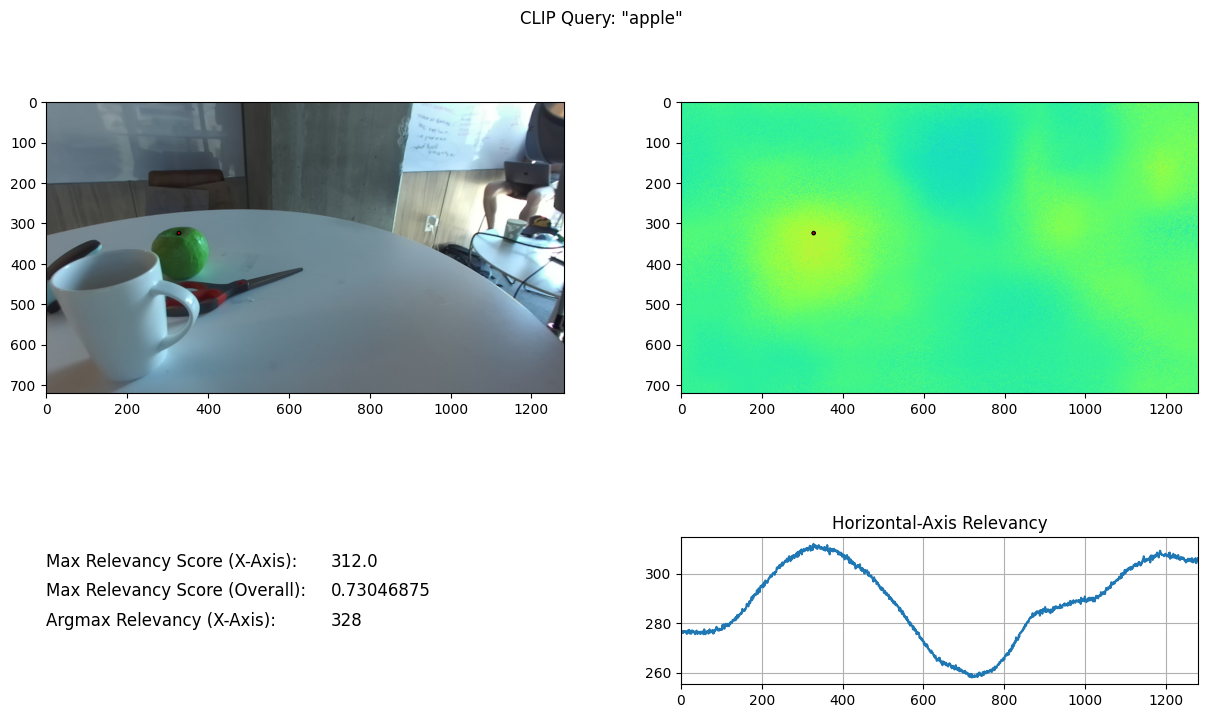

In [10]:
plot_clip_relevancy(torch.from_numpy(np_frame1).cuda(), "apple", max_index=21)